# 時系列クラスタリングを試す

https://aws.amazon.com/jp/blogs/news/cluster-time-series-data-for-use-with-amazon-forecast/

予測範囲：2021/7/1 00:00:00 - 2021/7/2 23:00:00 の48点

## 0.環境準備

In [2]:
import sys
print(sys.path)
sys.path.append('/usr/local/lib/python3.7/site-packages')
print('-------------------------------')
print(sys.path)

['/root/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']
-------------------------------
['/root/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.7/site-packages']


In [3]:
pip freeze # condaの環境が出力される？

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
aiobotocore==1.4.2
aiohttp==3.7.4.post0
aioitertools==0.8.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-project==0.8.3
argh==0.26.2
argon2-cffi==21.1.0
asn1crypto==1.3.0
astroid==2.8.4
astropy==4.0
async-timeout==3.0.1
atomicwrites==1.3.0
attrs==19.3.0
autopep8==1.4.4
autovizwidget @ file:///home/conda/feedstock_root/build_artifacts/autovizwidget_1630130557319/work
awscli==1.21.3
Babel==2.8.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.8.2
bitarray==1.2.1
bkcharts==0.2
bleach==4.1.0
bokeh==1.4.0
boto==2.49.0
boto3==1.19.3
botocore==1.22.3
Bottlenec

In [4]:
!pip freeze # コンテナの環境が出力される

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
aiobotocore==1.4.2
aiohttp==3.7.4.post0
aioitertools==0.8.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-project==0.8.3
argh==0.26.2
argon2-cffi==21.1.0
asn1crypto==1.3.0
astroid==2.8.4
astropy==4.0
async-timeout==3.0.1
atomicwrites==1.3.0
attrs==19.3.0
autopep8==1.4.4
autovizwidget @ file:///home/conda/feedstock_root/build_artifacts/autovizwidget_1630130557319/work
awscli==1.21.3
Babel==2.8.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.8.2
bitarray==1.2.1
bkcharts==0.2
bleach==4.1.0
bokeh==1.4.0
boto==2.49.0
boto3==1.19.3
botocore==1.22.3
Bottlenec

## 1.データセット読み込み

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('./electricityusage_20140101_20140630.csv', names=['date','demand','item_id'])

In [20]:
print(df.shape)
print(df['date'].min())
print(df['date'].max())
print(df['item_id'].nunique())
#print(df['item_id'].unique()) ### cliend_id一覧出力
print(type(df))
print(df.dtypes)
df.head()

(1606910, 3)
2014-01-01 01:00:00
2014-06-30 23:00:00
370
<class 'pandas.core.frame.DataFrame'>
date        object
demand     float64
item_id     object
dtype: object


,date,demand,item_id
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [35]:
### クラスタリングに時間かかるのでデータ絞る
#df = df[df.date >= '2014-06-01']
df = df[df.date >= '2014-06-25']  ### 22秒 at ml.m5.2xlarge

## 時系列クラスタをしていく

In [36]:
%pip install tslearn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [37]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

### 参考：時系列横持ちのデータが必要
https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Clustering_Preprocessing/02.%20Time%20Series%20Clustering%20Using%20DTW%20KMeans.ipynb

In [38]:
df_pivoted = pd.read_csv('../input_tscluster_test/df_pivoted.zip', low_memory=False)

In [39]:
df_pivoted.head()

,StockCode,2009-12-01 00:00:00,2009-12-02 00:00:00,2009-12-03 00:00:00,2009-12-04 00:00:00,2009-12-05 00:00:00,2009-12-06 00:00:00,2009-12-07 00:00:00,2009-12-08 00:00:00,2009-12-09 00:00:00,...,2010-11-30 00:00:00,2010-12-01 00:00:00,2010-12-02 00:00:00,2010-12-03 00:00:00,2010-12-04 00:00:00,2010-12-05 00:00:00,2010-12-06 00:00:00,2010-12-07 00:00:00,2010-12-08 00:00:00,2010-12-09 00:00:00
0,10002,12.0,0.0,7.0,73.0,0.0,49.0,2.0,12.0,0.0,...,12.0,60.0,1.0,8.0,0.0,1.0,25.0,8.0,13.0,44.0
1,10080,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10109,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10120,60.0,10.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,...,10.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,0.0
4,10125,5.0,0.0,0.0,46.0,0.0,8.0,20.0,1.0,22.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,0.0


In [40]:
df_pivoted.values

array([['10002', 12.0, 0.0, ..., 8.0, 13.0, 44.0],
       ['10080', 0.0, 1.0, ..., 0.0, 0.0, 0.0],
       ['10109', 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       ['DCGSLGIRL', 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ['DCGSSBOY', 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ['DCGSSGIRL', 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [41]:
# prepare data to laod to tslearn time_series_dataset object
df_pivoted.set_index('StockCode', inplace=True)

print(df_pivoted.shape, df_pivoted.columns)

df_pivoted.head()

(4605, 374) Index(['2009-12-01 00:00:00', '2009-12-02 00:00:00', '2009-12-03 00:00:00',
       '2009-12-04 00:00:00', '2009-12-05 00:00:00', '2009-12-06 00:00:00',
       '2009-12-07 00:00:00', '2009-12-08 00:00:00', '2009-12-09 00:00:00',
       '2009-12-10 00:00:00',
       ...
       '2010-11-30 00:00:00', '2010-12-01 00:00:00', '2010-12-02 00:00:00',
       '2010-12-03 00:00:00', '2010-12-04 00:00:00', '2010-12-05 00:00:00',
       '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
       '2010-12-09 00:00:00'],
      dtype='object', length=374)


,2009-12-01 00:00:00,2009-12-02 00:00:00,2009-12-03 00:00:00,2009-12-04 00:00:00,2009-12-05 00:00:00,2009-12-06 00:00:00,2009-12-07 00:00:00,2009-12-08 00:00:00,2009-12-09 00:00:00,2009-12-10 00:00:00,...,2010-11-30 00:00:00,2010-12-01 00:00:00,2010-12-02 00:00:00,2010-12-03 00:00:00,2010-12-04 00:00:00,2010-12-05 00:00:00,2010-12-06 00:00:00,2010-12-07 00:00:00,2010-12-08 00:00:00,2010-12-09 00:00:00
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,12.0,0.0,7.0,73.0,0.0,49.0,2.0,12.0,0.0,1.0,...,12.0,60.0,1.0,8.0,0.0,1.0,25.0,8.0,13.0,44.0
10080,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10109,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,60.0,10.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,6.0,...,10.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,0.0
10125,5.0,0.0,0.0,46.0,0.0,8.0,20.0,1.0,22.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,0.0


### 横持ちに変換する

In [42]:
df_piv = df.pivot(index='item_id', columns='date', values='demand')

In [43]:
df_piv

date,2014-06-25 00:00:00,2014-06-25 01:00:00,2014-06-25 02:00:00,2014-06-25 03:00:00,2014-06-25 04:00:00,2014-06-25 05:00:00,2014-06-25 06:00:00,2014-06-25 07:00:00,2014-06-25 08:00:00,2014-06-25 09:00:00,...,2014-06-30 14:00:00,2014-06-30 15:00:00,2014-06-30 16:00:00,2014-06-30 17:00:00,2014-06-30 18:00:00,2014-06-30 19:00:00,2014-06-30 20:00:00,2014-06-30 21:00:00,2014-06-30 22:00:00,2014-06-30 23:00:00
item_id,,,,,,,,,,,,,,,,,,,,,
client_0,1.903553,1.586294,1.903553,1.903553,1.903553,1.586294,2.220812,1.269036,0.634518,0.951777,...,0.634518,0.951777,0.951777,0.951777,0.951777,0.634518,0.951777,0.634518,1.269036,1.903553
client_1,27.382646,24.715505,21.514936,20.625889,20.448080,21.692745,23.826458,27.382646,33.072546,32.716927,...,30.227596,30.761024,28.271693,27.738265,30.227596,31.827881,33.428165,36.806543,32.361309,30.405405
client_10,46.944858,35.208644,31.110283,27.384501,29.247392,29.433681,24.217586,20.491803,24.590164,30.178838,...,25.894188,33.532042,30.551416,29.247392,34.090909,30.365127,35.767511,39.120715,37.630402,47.876304
client_100,536.149826,334.930314,232.578397,233.449477,179.442509,156.358885,158.101045,237.804878,236.498258,249.128920,...,934.668990,932.926829,952.526132,949.041812,945.993031,929.006969,917.682927,905.923345,964.285714,887.195122
client_101,428.335535,620.211361,678.665786,1269.484808,1517.833554,1501.651255,1395.640687,604.359313,329.590489,333.223250,...,880.449141,880.449141,879.458388,1247.027741,1297.556143,1280.383091,1217.965654,1124.504624,1055.151915,647.622193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_95,7.391304,5.507246,5.507246,6.811594,5.507246,5.362319,6.231884,3.913043,5.507246,16.521739,...,13.913043,19.130435,15.942029,16.376812,15.072464,9.275362,5.507246,6.231884,9.855072,10.289855
client_96,132.878151,121.323529,116.071429,120.273109,127.100840,121.848739,115.021008,138.655462,157.563025,288.865546,...,308.823529,273.634454,257.878151,293.592437,246.323529,176.470588,171.743697,153.886555,131.302521,113.445378
client_97,408.566722,278.006590,206.754530,198.105437,194.810544,185.337727,186.985173,184.925865,229.406919,236.820428,...,1052.718287,1065.074135,1065.897858,1063.838550,1063.426689,1064.662273,1044.892916,1064.250412,857.907743,490.939044


In [44]:
df_piv.values

array([[1.90355330e+00, 1.58629442e+00, 1.90355330e+00, ...,
        6.34517766e-01, 1.26903553e+00, 1.90355330e+00],
       [2.73826458e+01, 2.47155050e+01, 2.15149360e+01, ...,
        3.68065434e+01, 3.23613087e+01, 3.04054054e+01],
       [4.69448584e+01, 3.52086438e+01, 3.11102832e+01, ...,
        3.91207154e+01, 3.76304024e+01, 4.78763040e+01],
       ...,
       [4.08566722e+02, 2.78006590e+02, 2.06754530e+02, ...,
        1.06425041e+03, 8.57907743e+02, 4.90939044e+02],
       [7.45117188e+02, 4.65820312e+02, 4.02343750e+02, ...,
        1.73144531e+03, 1.80468750e+03, 1.39160156e+03],
       [9.48735020e+00, 6.82423435e+00, 8.15579228e+00, ...,
        1.05858855e+02, 9.62050599e+01, 3.06258322e+01]])

In [45]:
%%time

# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_piv.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

(370, 144, 1) (370, 144, 1)
CPU times: user 58.2 ms, sys: 8.91 ms, total: 67.1 ms
Wall time: 54.5 ms


## 【注意】fit_predict()結構時間かかる

In [46]:
%%time

# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 3

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)

CPU times: user 1min 11s, sys: 1min 16s, total: 2min 28s
Wall time: 22.4 s


In [47]:
import numpy as np

In [49]:
# backup clustering results
np.save(f"../tsl/data/tls_{algo}_cluster_labels", y_pred)

In [50]:
#model.to_pickle(f"./tsl/models/{algo}.pkl")
model.to_pickle(f"./{algo}.pkl")

In [60]:
print(len(y_pred))
y_pred

370


array([1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0,
       0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1,
       0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2,

In [53]:
import matplotlib.pyplot as plt


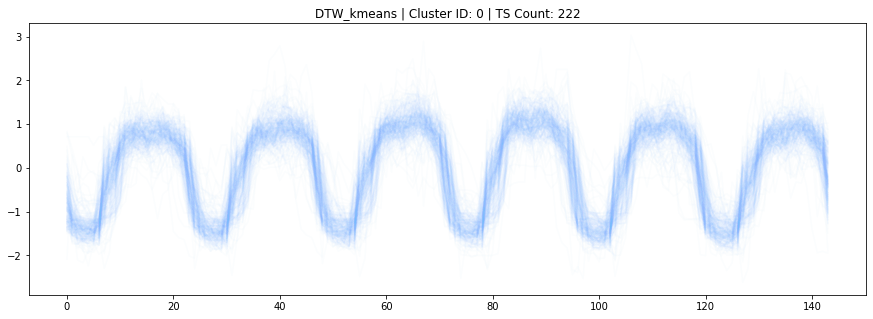

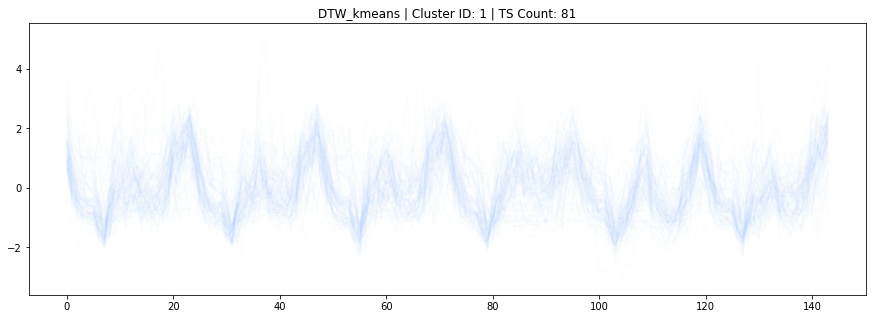

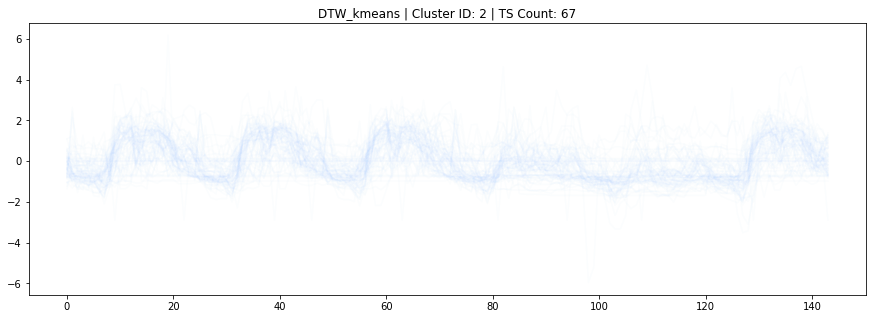

CPU times: user 2.47 s, sys: 21.3 ms, total: 2.49 s
Wall time: 2.63 s


In [59]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure(figsize=(15,5))
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.025)
    fig.savefig(f"../tsl/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [ ]:
1

In [63]:
# lookup dataframe with item_ids and corresponding labels
df_lbl = pd.DataFrame()
df_lbl['item_id'] = df_piv.index
df_lbl['label'] = y_pred

In [72]:
df_lbl

,item_id,label
0,client_0,1
1,client_1,0
2,client_10,1
3,client_100,0
4,client_101,1
...,...,...
365,client_95,2
366,client_96,2
367,client_97,0
368,client_98,0


In [73]:
df_lbl.to_csv('../tsl/data/lbl.csv', index=False)

## 可視化して確認

In [69]:
df_plot = df.pivot(index='date', columns='item_id', values='demand')

In [71]:
df_plot.head()

item_id,client_0,client_1,client_10,client_100,client_101,client_102,client_103,client_104,client_105,client_106,...,client_90,client_91,client_92,client_93,client_94,client_95,client_96,client_97,client_98,client_99
date,,,,,,,,,,,,,,,,,,,,,
2014-06-25 00:00:00,1.903553,27.382646,46.944858,536.149826,428.335535,900.000000,272.277228,125.273823,31.101614,14.614952,...,95.396931,27.128764,3.299492,16.422436,6.286014,7.391304,132.878151,408.566722,745.117188,9.487350
2014-06-25 01:00:00,1.586294,24.715505,35.208644,334.930314,620.211361,506.779661,99.257426,54.353779,31.576448,15.036537,...,92.728486,24.143302,2.030457,16.296109,3.666841,5.507246,121.323529,278.006590,465.820312,6.824234
2014-06-25 02:00:00,1.903553,21.514936,31.110283,232.578397,678.665786,458.474576,91.831683,52.163198,30.389364,15.036537,...,119.746498,22.975078,2.030457,16.675088,3.273965,5.507246,116.071429,206.754530,402.343750,8.155792
2014-06-25 03:00:00,1.903553,20.625889,27.384501,233.449477,1269.484808,454.661017,89.108911,51.341731,31.339031,12.225970,...,150.767178,22.455867,2.030457,17.054068,3.404924,6.811594,120.273109,198.105437,390.625000,7.656458
2014-06-25 04:00:00,1.903553,20.448080,29.247392,179.442509,1517.833554,354.661017,80.940594,52.710843,31.339031,11.804384,...,140.093396,22.585670,2.538071,15.538151,3.273965,5.507246,127.100840,194.810544,250.976562,6.990679


In [87]:
df_lbl[df_lbl.label==0]['item_id'][:5]

1      client_1
3    client_100
5    client_102
6    client_103
7    client_104
Name: item_id, dtype: object

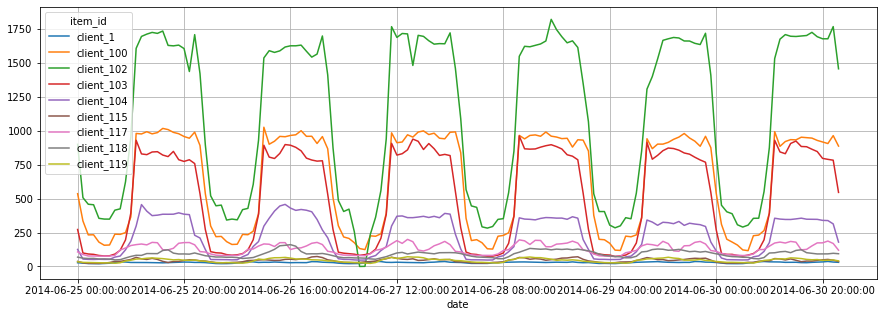

In [96]:
df_plot[df_lbl[df_lbl.label==0]['item_id'][:9]].plot(figsize=(15,5), grid=True)

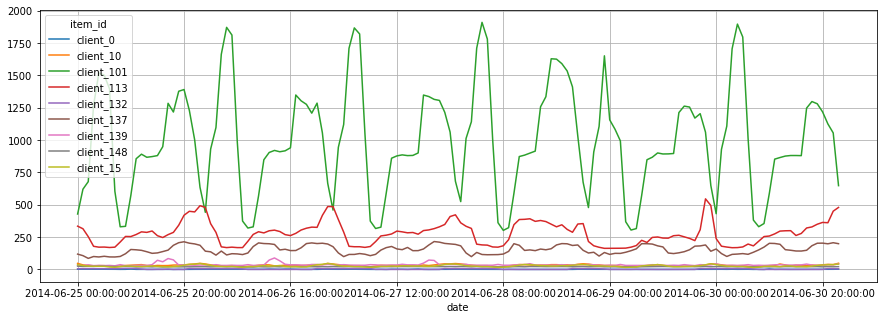

In [95]:
df_plot[df_lbl[df_lbl.label==1]['item_id'][:9]].plot(figsize=(15,5), grid=True)

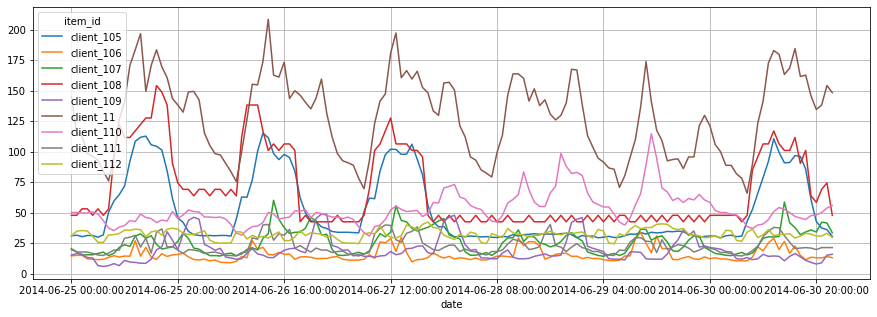

In [94]:
df_plot[df_lbl[df_lbl.label==2]['item_id'][:9]].plot(figsize=(15,5), grid=True)

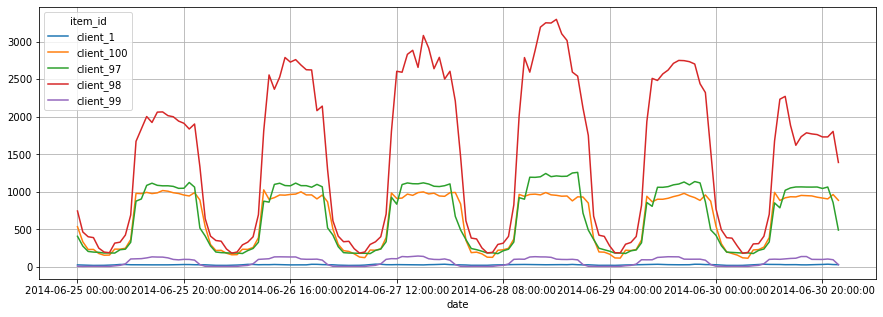

In [79]:
df_plot[['client_1','client_100','client_97','client_98','client_99']].plot(figsize=(15,5), grid=True)

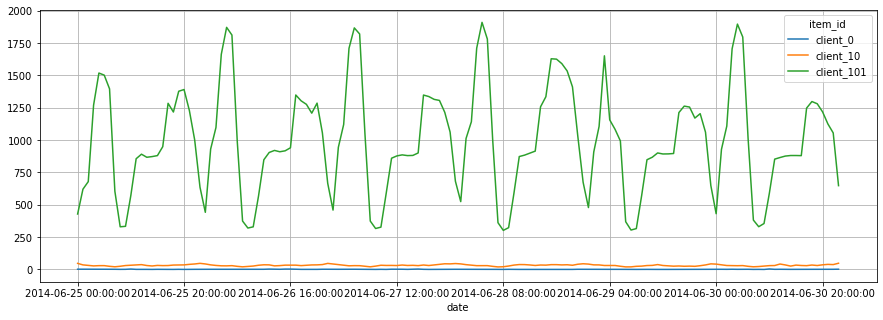

In [81]:
df_plot[['client_0','client_10','client_101']].plot(figsize=(15,5), grid=True)

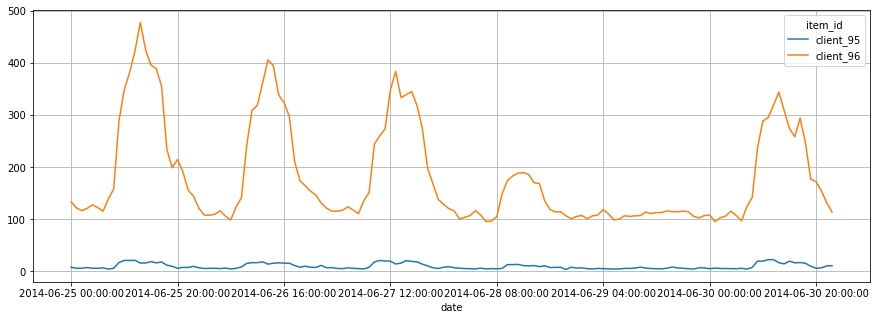

In [82]:
df_plot[['client_95','client_96']].plot(figsize=(15,5), grid=True)

# 以上

In [56]:
df['date'] = df['date'].str.replace('T',' ').str.replace('Z','')

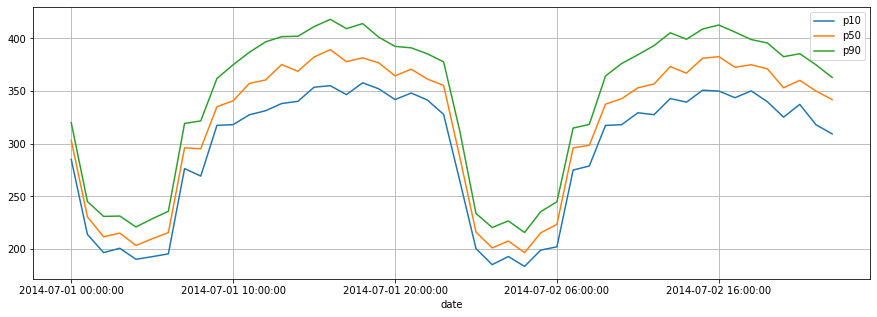

In [59]:
df[df.item_id=='client_224'].plot(x='date', figsize=(15,5), grid=True)

## 正解値を結合

In [60]:
df_true = pd.read_csv('../input/electricityusagedata.zip', names=['date','true','item_id'])

In [61]:
print(df_true.shape)
print(df_true['date'].min())
print(df_true['date'].max())
df_true.head()

(3241200, 3)
2014-01-01 01:00:00
2015-01-01 00:00:00


,date,true,item_id
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [62]:
df_true = df_true[(df_true.date>='2014-07-01')&(df_true.date<='2014-07-03')]

In [63]:
print(df_true.shape)
print(df_true['date'].min())
print(df_true['date'].max())
df_true.head()

(17760, 3)
2014-07-01 00:00:00
2014-07-02 23:00:00


,date,true,item_id
1606910,2014-07-01 00:00:00,1.586294,client_0
1606911,2014-07-01 00:00:00,29.160740,client_1
1606912,2014-07-01 00:00:00,1.737619,client_2
1606913,2014-07-01 00:00:00,119.410569,client_3
1606914,2014-07-01 00:00:00,51.219512,client_4


In [64]:
df_mrg = pd.merge(df, df_true, how='left', on=['date','item_id'])

In [65]:
df_mrg

,item_id,date,p10,p50,p90,true
0,client_224,2014-07-01 00:00:00,285.044891,303.226349,319.947937,275.036585
1,client_224,2014-07-01 01:00:00,213.835144,230.497742,245.040894,244.568293
2,client_224,2014-07-01 02:00:00,196.585632,211.607986,230.921890,240.280488
3,client_224,2014-07-01 03:00:00,200.693100,215.059418,231.289169,240.036585
4,client_224,2014-07-01 04:00:00,190.219391,203.348602,220.894562,236.617073
...,...,...,...,...,...,...
17755,client_166,2014-07-02 19:00:00,79.258774,87.034119,99.178917,96.537090
17756,client_166,2014-07-02 20:00:00,75.411728,84.209511,94.647430,93.502140
17757,client_166,2014-07-02 21:00:00,73.604919,79.501030,90.540291,81.191155
17758,client_166,2014-07-02 22:00:00,53.347622,61.209949,69.948036,70.841655


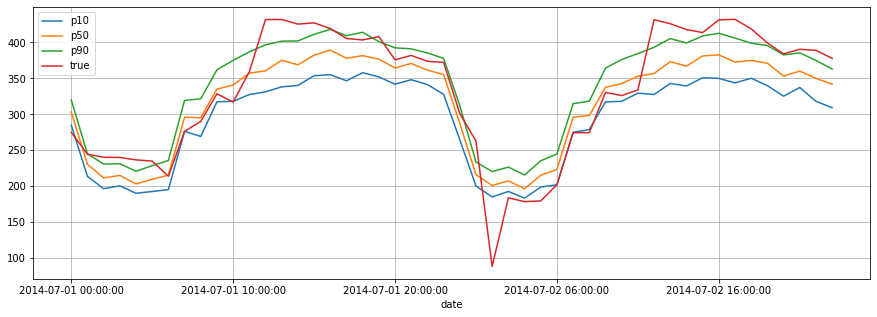

In [66]:
df_mrg[df_mrg.item_id=='client_224'].plot(x='date', figsize=(15,5), grid=True)

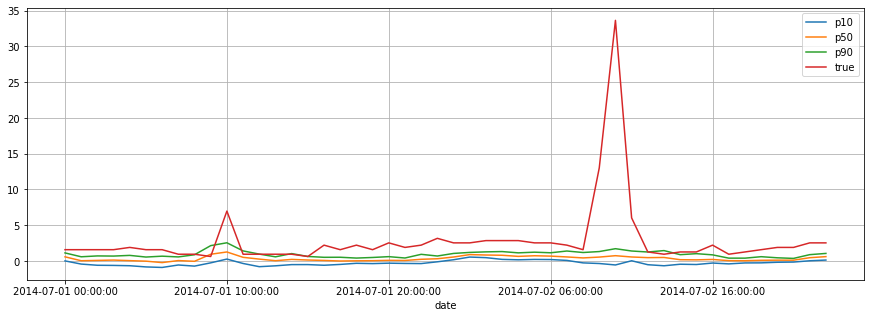

In [68]:
df_mrg[df_mrg.item_id=='client_0'].plot(x='date', figsize=(15,5), grid=True)

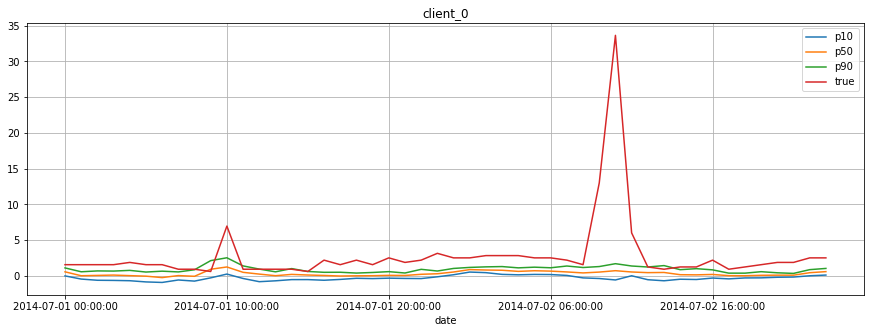

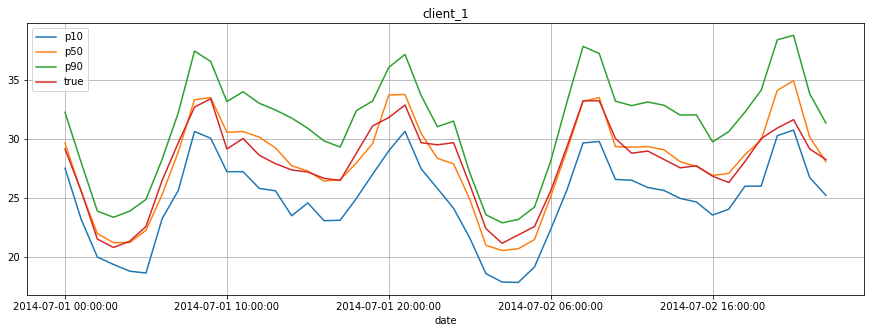

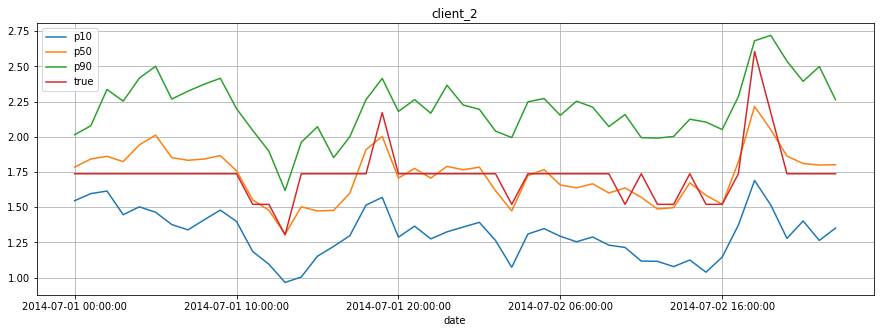

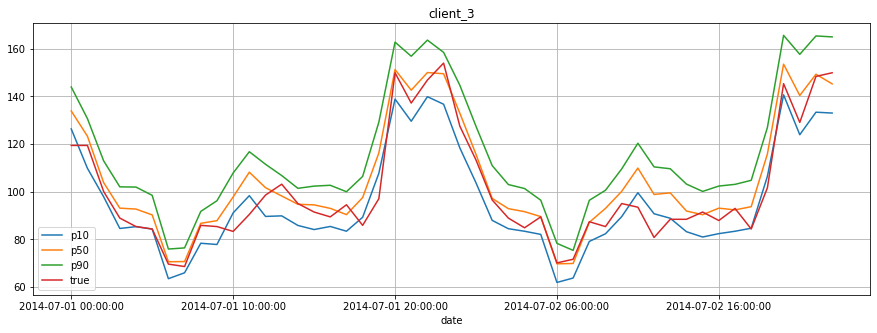

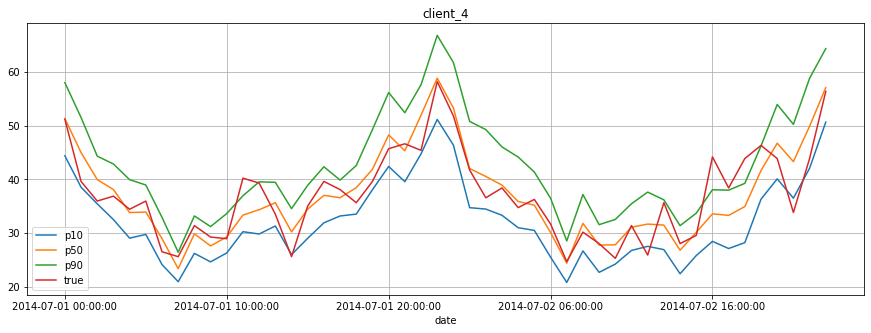

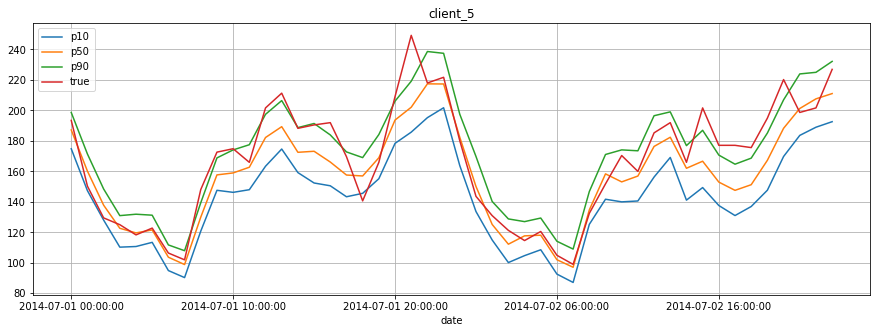

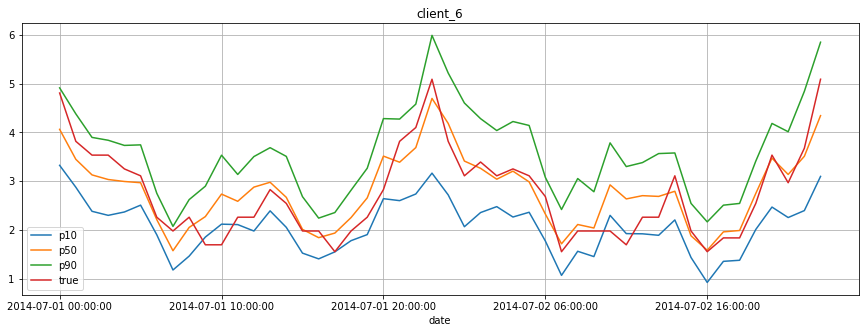

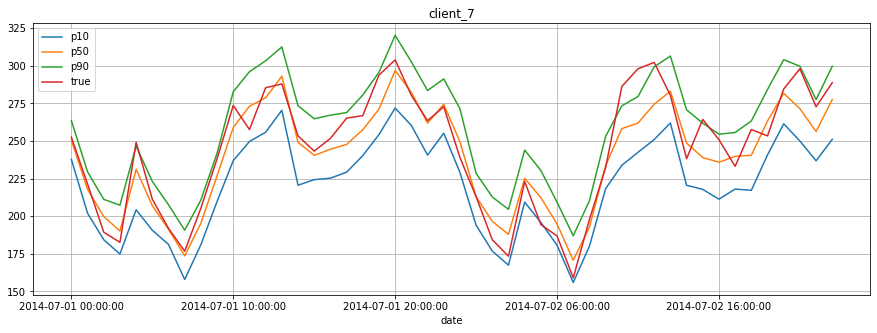

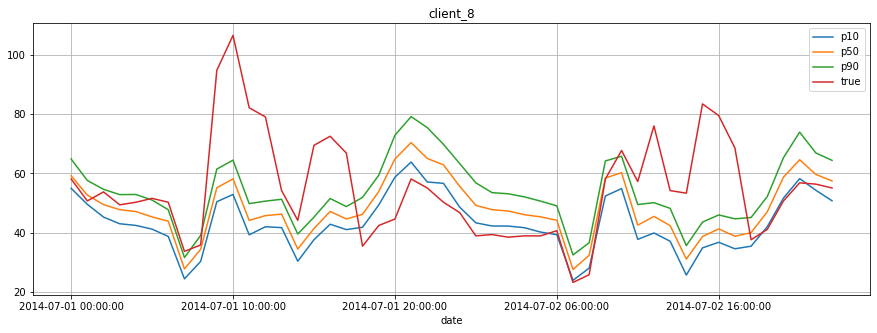

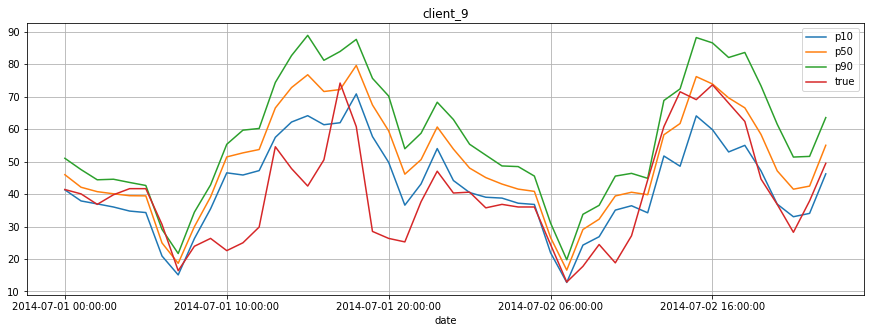

In [72]:
for i in range(10):
    df_mrg[df_mrg.item_id==f'client_{i}'].plot(x='date', title=f'client_{i}', figsize=(15,5), grid=True)

In [ ]:
df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target']

In [7]:
print(df.shape)
print(df['timestamp'].min())
print(df['timestamp'].max())
df.head()

(3241200, 3)
2014-01-01 01:00:00
2015-01-01 00:00:00


,timestamp,demand,client
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [8]:
df['client'] = df['client'].str.replace('client_','').astype(int)

## 2.特徴量生成

### 1)時刻型に変換し、特徴量（時間帯、曜日）を抽出

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df['num_of_week'] = df['timestamp'].dt.dayofweek

In [11]:
df['hour'] = df['timestamp'].dt.hour

### 2)clientごとに時間差の値を特徴量にもつ（36hより前である必要がある）

In [12]:
df["before_36h"] = df.groupby(['client']).shift(36)['demand'].reset_index()['demand']
df["before_37h"] = df.groupby(['client']).shift(37)['demand'].reset_index()['demand']
df["before_38h"] = df.groupby(['client']).shift(38)['demand'].reset_index()['demand']
df["before_48h"] = df.groupby(['client']).shift(48)['demand'].reset_index()['demand']
df["before_72h"] = df.groupby(['client']).shift(72)['demand'].reset_index()['demand']
df["before_96h"] = df.groupby(['client']).shift(96)['demand'].reset_index()['demand']

### 3)clientごとに期間で集約する

In [13]:
df = df.sort_values(["client","timestamp"]).reset_index()
df['mean_24h'] = df.groupby(['client']).rolling(24)['demand'].mean().reset_index()['demand']
df['var_24h'] = df.groupby(['client']).rolling(24)['demand'].var().reset_index()['demand']

In [14]:
#df = df.sort_values(["client","timestamp"]).reset_index()
#df['mean_24h_before_36h'] = df.groupby(['client']).rolling(2)['demand'].mean().reset_index()['demand']

In [15]:
df["mean_24h_before_36h"] = df.groupby(['client']).shift(36)['mean_24h'].reset_index()['mean_24h']
df["var_24h_before_36h"] = df.groupby(['client']).shift(36)['var_24h'].reset_index()['var_24h']

In [16]:
df[df.client==21].head()

,index,timestamp,demand,client,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
183960,21,2014-01-01 01:00:00,29.887920,21,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183961,391,2014-01-01 02:00:00,28.953923,21,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183962,761,2014-01-01 03:00:00,28.953923,21,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183963,1131,2014-01-01 04:00:00,25.373599,21,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183964,1501,2014-01-01 05:00:00,23.661270,21,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df[df.client==21].tail()

,index,timestamp,demand,client,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
192715,3239371,2014-12-31 20:00:00,43.586550,21,2,20,28.798257,25.062267,25.996264,53.237858,42.029888,45.143213,25.289280,47.597890,36.795610,94.835153
192716,3239741,2014-12-31 21:00:00,40.317559,21,2,21,45.143213,28.798257,25.062267,47.478207,42.808219,40.940224,25.451432,51.997619,37.042082,97.544219
192717,3240111,2014-12-31 22:00:00,36.581569,21,2,22,51.992528,45.143213,28.798257,36.581569,41.718555,36.737235,25.658987,55.694928,37.113429,99.637520
192718,3240481,2014-12-31 23:00:00,32.222914,21,2,23,52.148194,51.992528,45.143213,32.222914,33.156912,36.892902,25.886000,57.460307,37.450706,107.252683
192719,3240851,2015-01-01 00:00:00,33.935243,21,3,0,45.765878,52.148194,51.992528,33.623910,30.666252,33.468244,26.184361,60.150056,37.353414,105.317417


In [18]:
feature_col = [
    'client',
    'num_of_week',
    'hour',
    'before_36h',
    'before_37h',
    'before_38h',
    'before_48h',
    'before_72h',
    'before_96h',
    'mean_24h_before_36h',
    'var_24h_before_36h'
]

## 3.データ分割
all:2014-01-01 01:00:00 〜 2015-01-01 00:00:00  
train:2014-01-01 01:00:00 〜 2014-12-29 00:00:00  
valid:2014-12-29 01:00:00 〜 2014-12-30 12:00:00(36h)  
test:2014-12-30 13:00:00 〜 2015-01-01 00:00:00(36h)  

In [19]:
df_train = df[df.timestamp <= '2014-12-29 00:00:00']

In [20]:
df_valid = df[(df.timestamp >= '2014-12-29 01:00:00') & (df.timestamp <= '2014-12-30 12:00:00')]

In [21]:
df_test = df[df.timestamp >= '2014-12-30 13:00:00']

In [22]:
df_train[df_train.client==21].shape

(8688, 16)

In [23]:
df_valid[df_valid.client==21].shape

(36, 16)

In [24]:
df_test[df_test.client==21].shape

(36, 16)

In [25]:
tr_x = df_train[feature_col]
tr_y = df_train['demand']

In [26]:
va_x = df_valid[feature_col]
va_y = df_valid['demand']

In [27]:
test_x = df_test[feature_col]
test_y = df_test[['timestamp','client','demand']]

In [35]:
import xgboost as xgb

In [36]:
dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)

## 4.モデル学習
誤差はRMSEを用いる

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/metrics.html

In [37]:
import xgboost as xgb

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
#fit by best params
regressor = xgb.XGBRegressor(n_estimators=50)

In [40]:
regressor.fit(tr_x, tr_y, eval_metric="rmse", eval_set=[(va_x, va_y)])

[0]	validation_0-rmse:1692.89270
[1]	validation_0-rmse:1249.69665
[2]	validation_0-rmse:955.56213
[3]	validation_0-rmse:751.86902
[4]	validation_0-rmse:629.17120
[5]	validation_0-rmse:536.28491
[6]	validation_0-rmse:473.82040
[7]	validation_0-rmse:438.41156
[8]	validation_0-rmse:406.06827
[9]	validation_0-rmse:393.50272
[10]	validation_0-rmse:380.91464
[11]	validation_0-rmse:373.27734
[12]	validation_0-rmse:367.40170
[13]	validation_0-rmse:361.12176
[14]	validation_0-rmse:360.40811
[15]	validation_0-rmse:358.21576
[16]	validation_0-rmse:357.26431
[17]	validation_0-rmse:357.21787
[18]	validation_0-rmse:356.47800
[19]	validation_0-rmse:356.45084
[20]	validation_0-rmse:355.84372
[21]	validation_0-rmse:355.83597
[22]	validation_0-rmse:355.82892
[23]	validation_0-rmse:357.84653
[24]	validation_0-rmse:357.05560
[25]	validation_0-rmse:357.05273
[26]	validation_0-rmse:357.05133
[27]	validation_0-rmse:357.13977
[28]	validation_0-rmse:357.14246
[29]	validation_0-rmse:357.14414
[30]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 5.モデル評価

### testデータでのRMSE

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [42]:
test_y

,timestamp,client,demand
8724,2014-12-30 13:00:00,0,0.951777
8725,2014-12-30 14:00:00,0,1.269036
8726,2014-12-30 15:00:00,0,0.951777
8727,2014-12-30 16:00:00,0,4.124365
8728,2014-12-30 17:00:00,0,3.489848
...,...,...,...
3241195,2014-12-31 20:00:00,369,8729.729730
3241196,2014-12-31 21:00:00,369,8216.216216
3241197,2014-12-31 22:00:00,369,8297.297297
3241198,2014-12-31 23:00:00,369,7527.027027


In [43]:
### RMSEを出力
np.sqrt(mean_squared_error(test_y['demand'], regressor.predict(test_x)))

411.01351378049736

### 重要度の可視化

In [45]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 72.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 52.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

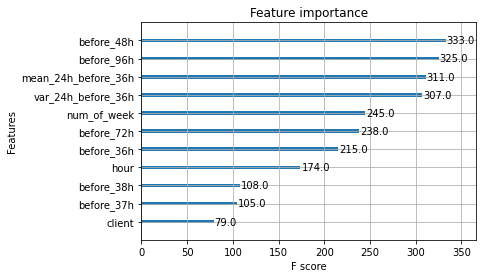

In [46]:
xgb.plot_importance(regressor)

## 6.推論（予測）
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py

In [47]:
regressor.predict(test_x)

array([1.1317768e+01, 1.1317768e+01, 1.1317768e+01, ..., 1.8498859e+04,
       1.8017615e+04, 1.7940875e+04], dtype=float32)

## 7.推論結果の可視化
client_21について  
正解データ  
Amazon Foreast  
xgboost  

In [48]:
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.client==21]), columns=['xgb'])

In [49]:
df_xgb

,xgb
0,31.295288
1,24.518488
2,34.730373
3,34.730373
4,34.730373
5,41.507172
6,51.620995
7,51.620995
8,47.542473
9,47.542473


In [50]:
df_y = pd.DataFrame(test_y[test_y.client==21]['demand'], columns=['demand']).reset_index(drop=True)

In [51]:
df_y

,demand
0,21.948941
1,28.642590
2,40.317559
3,46.077210
4,40.940224
5,45.143213
6,43.119552
7,38.605230
8,36.425903
9,31.600249


### Foreastの結果

In [52]:
df_forecast = pd.read_csv('../AmazonForecast_predict/my_forecast_export_drop1week_2021-03-03T07-51-36Z_part1.csv')

In [53]:
df_forecast['item_id'].unique()

array(['client_201', 'client_249', 'client_357', 'client_324',
       'client_75', 'client_274', 'client_234', 'client_326',
       'client_313', 'client_260', 'client_133', 'client_318',
       'client_289', 'client_361', 'client_174', 'client_109',
       'client_184', 'client_21', 'client_86', 'client_32', 'client_82',
       'client_177', 'client_10', 'client_226', 'client_103',
       'client_159', 'client_169', 'client_266', 'client_241',
       'client_295', 'client_306', 'client_36', 'client_47', 'client_124',
       'client_158', 'client_230', 'client_285', 'client_35',
       'client_349', 'client_170', 'client_144', 'client_128',
       'client_46', 'client_272', 'client_68', 'client_110', 'client_253',
       'client_252', 'client_191', 'client_23', 'client_267', 'client_9',
       'client_0', 'client_31', 'client_51', 'client_189', 'client_354'],
      dtype=object)

In [54]:
df_result = df_forecast[df_forecast.item_id=='client_21'].reset_index(drop=True)

In [55]:
df_result

,item_id,date,p10,p50,p90
0,client_21,2014-12-30T13:00:00Z,21.333923,25.132877,28.770159
1,client_21,2014-12-30T14:00:00Z,28.073387,32.898338,37.092026
2,client_21,2014-12-30T15:00:00Z,38.639301,43.846355,50.444412
3,client_21,2014-12-30T16:00:00Z,41.978588,46.520233,52.283760
4,client_21,2014-12-30T17:00:00Z,39.904404,46.363640,51.784618
5,client_21,2014-12-30T18:00:00Z,43.310654,50.251816,59.930252
6,client_21,2014-12-30T19:00:00Z,48.920353,55.080643,62.824970
7,client_21,2014-12-30T20:00:00Z,45.416351,52.224514,60.060890
8,client_21,2014-12-30T21:00:00Z,36.452190,43.848927,52.385162
9,client_21,2014-12-30T22:00:00Z,32.266903,38.022995,44.000668


<AxesSubplot:xlabel='date'>

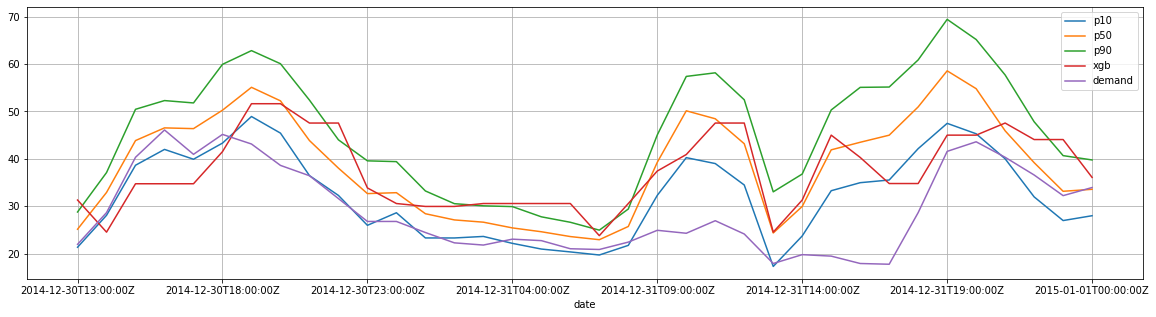

In [56]:
pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

# XGBoostの利点
特徴量の重要度がわかる

【デメリット】
コードのデバッグが大変
特徴量を作り込む必要あり
ハイパーパラメータのチューニング
